# Fine-tuning InceptionV3 для классификации цветов

InceptionV3 архитектура ( https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html ):
<img src="https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.png" style="width:50%">

Датасет классификации цветов (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) состоит из 102 видов цветов встречаемых в Великобритании. Для каждого класса есть от 40 до 258 примеров, чего мало для обучения с нуля:
<img src="http://bennycheung.github.io/images/deep-transfer-learning-on-small-dataset/flower_train_samples_700.jpg" style="width:50%">

# Импорты

In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile

Using TensorFlow backend.


1.13.1
2.2.4


In [0]:
# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

# Загрузим данные

In [3]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/ZEMUSHKA/skillfactory-dl/master/setup_google_colab.py -O setup_google_colab.py -q
import setup_google_colab
setup_google_colab.download_flowers()

shred: setup_google_colab.py: failed to open for writing: No such file or directory


# Подготовим картинки

In [0]:
# размер картинки для сети
IMG_SIZE = 250

In [0]:
# парсим картинку из байтов jpeg файла
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Будем вырезать центр картинки:
<img src="http://qaru.site/img/9ba3629c921997be74d3d661643d2672.jpg" 
    style="width:50%">

In [0]:
def image_center_crop(img):
    """
    На вход [h, w, 3] numpy array.
    На выходе [min(h, w), min(h, w), 3] numpy array.
    """   
    h, w = img.shape[0], img.shape[1]
    pad_left = 0
    pad_right = 0
    pad_top = 0
    pad_bottom = 0
    if h > w:
        diff = h - w
        pad_top = diff - diff // 2
        pad_bottom = diff // 2
    else:
        diff = w - h
        pad_left = diff - diff // 2
        pad_right = diff // 2
    
    cropped_img = img[pad_top:h-pad_bottom, pad_left:w-pad_right, :]
    
    return cropped_img

In [0]:
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # парсим jpeg
    img = image_center_crop(img)  # центральный вырез
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # изменяем размер картинки под нашу модель
    if normalize_for_model:
        img = img.astype("float32")  # подготовим к нормировке
        img = keras.applications.inception_v3.preprocess_input(img)  # нужно использовать такую же нормировку как при обучении InceptionV3
    return img

In [0]:
# читает один файл из архива (медленно)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 591, 3)


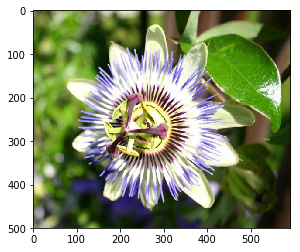

(250, 250, 3)


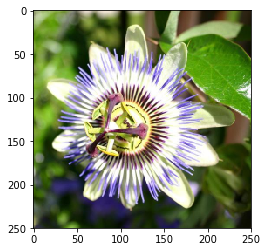

In [9]:
# протестируем вырез
raw_bytes = read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

# Готовимся к обучению


In [10]:
# прочитаем все названия файлов прям из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

all_files = sorted(get_all_filenames("102flowers.tgz"))
all_labels = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
# all_files и all_labels теперь выровнены
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [0]:
# трейн / тест
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [0]:
# извлекает из архива байты jpeg картинки и таргет
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        while True:
            m = f.next()
            if m is None:
                break
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [0]:
# генератор батчей
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    batch = []
    for item in items:
        batch.append(item)
        if len(batch) == batch_size:
            yield batch
            batch = []
    # последний
    if batch:
        yield batch

In [0]:
def train_generator(files, labels):
    while True:  # бесконечно повторяем данные
        for batch in batch_generator(raw_generator_with_label_from_tar(
                "102flowers.tgz", files, labels), BATCH_SIZE):
            # готовим батч
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # картинки стекаем в 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # one-hot для таргета [batch_size, num_classes]
            batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

(32, 250, 250, 3) (32, 102)


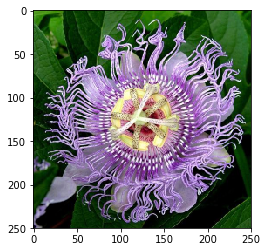

In [15]:
# тестируем генератор
for _ in train_generator(tr_files, tr_labels):
    print(_[0].shape, _[1].shape)
    plt.imshow(np.clip(_[0][0] / 2. + 0.5, 0, 1))
    break

# Обучение модели


Будем файн-тьюнить InceptionV3

In [0]:
# чистите сессию иначе кончится память!
s = reset_tf_session()

In [0]:
def inception(use_imagenet=True):
    # предобученная сеть без последнего слоя (потому что у нас другие классы)
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # точно так же, как в оригинальной модели, сначала делаем глобальный пулинг
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # софтмакс для новых классов
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [18]:
model = inception()

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 2s 0us/step


In [19]:
# много буков
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 124, 124, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 124, 124, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
# сколько слоев
print(len(model.layers))

313


In [0]:
# все слои обучаемы
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # быстрее настраиваем параметры батч норма!
        layer.momentum = 0.9
    
# fine-tuning только для 50 последних слоев
for layer in model.layers[:-50]:
    # батч норм должен настраивать свои параметры для новых данных! а иначе фиксируем слой!
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adamax(lr=1e-2),  # шаг побольше потому что учим только последние слои
    metrics=['accuracy']
)

Целимся в ~0.93 validation accuracy.

In [26]:
# тут одна эпоха - это 1/8 данных
# по сути делаем две честных эпохи обучения
model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    epochs=2 * 8,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    verbose=1
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/16
25/25 [==============================] - 18s 724ms/step - loss: 3.8472 - acc: 0.3150 - val_loss: 2.3645 - val_acc: 0.4896
Epoch 2/16
25/25 [==============================] - 9s 353ms/step - loss: 2.0194 - acc: 0.5637 - val_loss: 1.1526 - val_acc: 0.7214
Epoch 3/16
25/25 [==============================] - 9s 355ms/step - loss: 1.0478 - acc: 0.7538 - val_loss: 0.6623 - val_acc: 0.8411
Epoch 4/16
25/25 [==============================] - 9s 355ms/step - loss: 0.7983 - acc: 0.8150 - val_loss: 0.5678 - val_acc: 0.8698
Epoch 5/16
25/25 [==============================] - 9s 364ms/step - loss: 0.6024 - acc: 0.8562 - val_loss: 0.5450 - val_acc: 0.8911
Epoch 6/16
25/25 [==============================] - 9s 356ms/step - loss: 0.5571 - acc: 0.8600 - val_loss: 0.3612 - val_acc: 0.9062
Epoch 7/16
25/25 [==============================] - 9s 359ms/step - loss: 0.4538 - acc: 0.8900 - val_loss: 0.2278 - val_acc: 0.9401
Epoch 8/16
25/25 [=========

In [27]:
# accuracy на валидации
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE
)[1]
print(test_accuracy)

0.9522058823529411
